In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU

In [2]:
Autoencoder = tf.keras.models.load_model('k_fold_best_model_test2', compile=False)

In [3]:
phis=[0.93,1.0,1.10] 
Ts=[1160,1200,1130]

name_11='State_space_cte_pressure_T' 
name_12='_phi_'
name_21='Reaction_rates_cte_pressure_T'
name_22='_phi_'

end='.csv'

In [4]:
def hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values):
    cantera_sources=cantera_sources.add_suffix('w')
    cantera_sources=cantera_sources.iloc[:,1:] #for taking out the timestep as data 
    
    cantera_time=cantera_species.iloc[:,1]
    cantera_temperature=cantera_species.iloc[:,2]
    cantera_pressure=cantera_species.iloc[:,3]
    
    cantera_species_fractions=cantera_species.iloc[:,4:12]
    
    n_columns_mass_fraction=np.shape(cantera_species_fractions)[1]
    
    cantera_sources=cantera_sources.loc[:,(cantera_sources!=0).any(axis=0)]
    cantera_sources=cantera_sources.loc[:, (cantera_sources != cantera_sources.iloc[0]).any()]
    
    n_columns_source=np.shape(cantera_sources)[1]
    
    cantera_data=pd.concat([cantera_time, cantera_temperature,cantera_species_fractions,cantera_sources],axis=1)

    maximum_values=maximum_values.iloc[0,1:]
    maximum_values=maximum_values.to_numpy()
    
    iterations=np.shape(cantera_data)[1]
    
    #cantera_data.divide(maximum_values)
    for j in range(iterations):
        cantera_data.iloc[:,j]=cantera_data.iloc[:,j]/(maximum_values[j])
    
    cantera_data_shift=cantera_data.loc[1:,:]
    cantera_data_shift=cantera_data_shift.add_suffix('shift')
    
    cantera_data=cantera_data.reset_index()
    cantera_data_shift=cantera_data_shift.reset_index()
    
    cantera_data=cantera_data.iloc[:,1:]
    cantera_data_shift=cantera_data_shift.iloc[:,1:]

    cantera_data=cantera_data.iloc[0:(np.shape(cantera_data_shift)[0]),:]
    
    data_all=pd.concat([cantera_data, cantera_data_shift], axis=1)

    columns=data_all.columns.to_list()
    
    return data_all, n_columns_source, n_columns_mass_fraction, columns

In [5]:
k=1
cantera_species=pd.read_csv(name_11+str(Ts[k])+name_12+str(phis[k])+end)
cantera_species=pd.DataFrame(cantera_species)

cantera_sources=pd.read_csv(name_21+str(Ts[k])+name_22+str(phis[k])+end)
cantera_sources=pd.DataFrame(cantera_sources)

maximum_values=pd.read_csv('maximum_values_Phi_T_Sampling.csv')
maximum_values=pd.DataFrame(maximum_values)

In [6]:
dataset, n_columns_source, n_columns_mass_fraction, columns=hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values)

In [7]:
results=Autoencoder.decoder(Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy()))).numpy()

In [8]:
interest_vector=['H2O','O2','H2','T[K]','OH','HO2','H2O2']

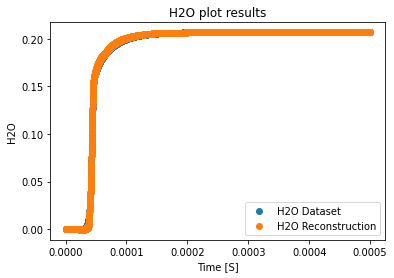

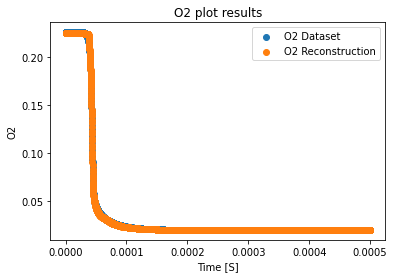

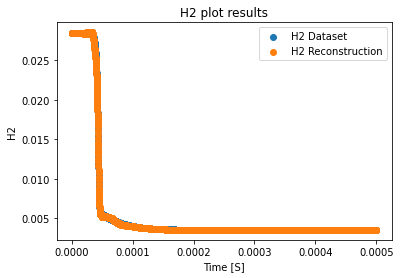

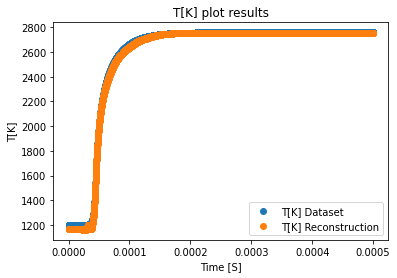

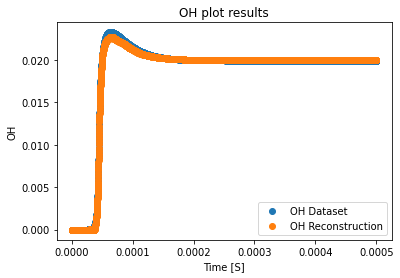

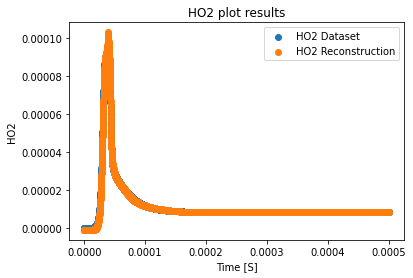

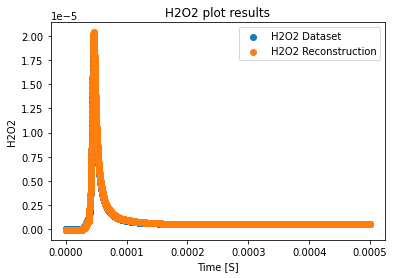

In [9]:
t_index=columns.index('t[s]shift')
t_trans=maximum_values.columns.get_loc('t[s]')
time_plot=(dataset.iloc[:,t_index])*maximum_values.iloc[0,t_trans]
    
for k in range(len(interest_vector)):
    original_index=columns.index(interest_vector[k]+'shift')
    #print(columns[original_index])
    results_index=columns.index(interest_vector[k]) #minues one due to the time column presence 
    #print(columns[results_index])
    #print(results_index-1)
    transformation_index=maximum_values.columns.get_loc(interest_vector[k])
    plot_name=interest_vector[k]+'.png'
    
    input_label=interest_vector[k]+' Dataset'
    output_label=interest_vector[k]+' Reconstruction'
    
    original=(dataset.iloc[:,original_index]).to_numpy()
    #original=original*transformation_values[1,original_index]
    #original=original+transformation_values[0,original_index]
    #original=np.exp(original)-1
    original=original*maximum_values.iloc[0,transformation_index]
    
    output=(results[:,results_index-1])
    #output=output*transformation_values[1,results_index]
    #output=output+transformation_values[0,results_index]
    #output=np.exp(output)-1
    output=output*maximum_values.iloc[0,transformation_index]
    
    plt.figure(k)
    plt.scatter(time_plot,original, label=input_label)
    plt.scatter(time_plot,output, label=output_label)
    plt.title(interest_vector[k]+' plot results')
    plt.xlabel('Time [S]')
    plt.ylabel(interest_vector[k])
    plt.legend()

In [10]:
latent_space=Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy())).numpy()

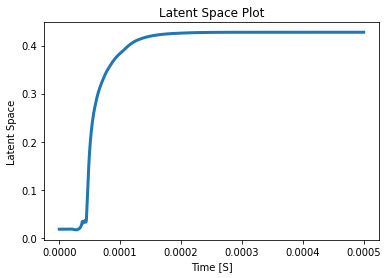

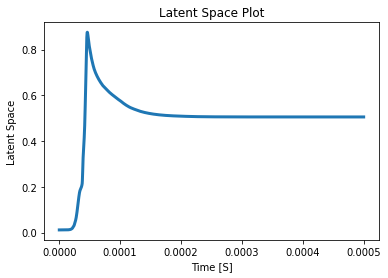

In [11]:
reduced_size=np.shape(latent_space)[1]

if reduced_size==1:
    plt.figure()
    plt.plot(time_plot,latent_space,linewidth=3)
    plt.title('Latent Space Plot')
    plt.xlabel('Time [S]')
    plt.ylabel('Latent Space')
else: 
    for i in range(reduced_size):
            plt.figure(i)
            plt.plot(time_plot,latent_space[:,i],linewidth=3)
            plt.title('Latent Space Plot')
            plt.xlabel('Time [S]')
            plt.ylabel('Latent Space')

In [43]:
plt.figure(figsize=(18,15),dpi=600)
plt.plot(time_plot,latent_space[:,0],linewidth=3,color='crimson')
plt.plot(time_plot,dataset.loc[:,'T[K]'],linewidth=3,color='k',linestyle='dashed')
#plt.title('Latent Space Plot')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('Normalized Magnitude',fontsize=22)
plt.xlabel('Time [S]',fontsize=22)
plt.savefig('latent_variable_comparison_z0.jpg',dpi=600)


In [44]:
plt.figure(figsize=(18,15),dpi=600)
plt.plot(time_plot,latent_space[:,1],linewidth=3, color='crimson')
plt.plot(time_plot,dataset.loc[:,'O'],linewidth=3,color='k',linestyle='dashed')
#plt.title('Latent Space Plot')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('Normalized Magnitude',fontsize=22)
plt.xlabel('Time [S]',fontsize=22)
plt.savefig('latent_variable_comparison_z1.jpg',dpi=600)

In [14]:
corr_dataset=dataset.iloc[:,1:2+n_columns_mass_fraction+n_columns_source]
corr_columns=corr_dataset.columns.to_list()
corr_dataset

,T[K],H2,H,O2,OH,O,H2O,HO2,H2O2,H2w,Hw,O2w,OHw,Ow,H2Ow,HO2w,H2O2w
0,0.430892,0.885458,1.150531e-09,0.997196,5.144054e-11,7.240271e-11,1.573112e-12,0.000002,3.624549e-10,-2.801616e-08,5.996225e-08,-6.379635e-08,7.524353e-09,7.317545e-09,3.395073e-10,1.337874e-04,3.436094e-08
1,0.430892,0.885458,2.286126e-09,0.997196,1.754366e-10,2.720046e-10,1.094616e-11,0.000004,1.451762e-09,-2.881323e-08,5.968010e-08,-6.585636e-08,1.193320e-08,1.332981e-08,1.157881e-09,1.344889e-04,6.887562e-08
2,0.430892,0.885458,3.423431e-09,0.997196,3.440388e-10,5.769386e-10,3.306626e-11,0.000005,3.271229e-09,-2.992742e-08,6.009707e-08,-6.791946e-08,1.483538e-08,1.835911e-08,2.270654e-09,1.351914e-04,1.035429e-07
3,0.430892,0.885458,4.573670e-09,0.997196,5.435719e-10,9.706971e-10,7.112930e-11,0.000007,5.824084e-09,-3.127617e-08,6.101010e-08,-7.000604e-08,1.697692e-08,2.263940e-08,3.587572e-09,1.359020e-04,1.383639e-07
4,0.430892,0.885458,5.745061e-09,0.997196,7.671048e-10,1.440724e-09,1.274551e-10,0.000009,9.113597e-09,-3.281374e-08,6.230310e-08,-7.213099e-08,1.870887e-08,2.634644e-08,5.062888e-09,1.366258e-04,1.733413e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,0.991159,0.110547,1.196932e-01,0.088078,8.474259e-01,2.147999e-01,9.297617e-01,0.073162,2.612068e-02,-1.669582e-09,-3.309385e-09,-1.685345e-09,-9.397404e-09,-5.369258e-09,3.748735e-09,-3.228181e-09,-9.060090e-10
4995,0.991159,0.110547,1.196932e-01,0.088078,8.474259e-01,2.147999e-01,9.297617e-01,0.073162,2.612068e-02,-1.663805e-09,-3.297928e-09,-1.679490e-09,-9.365483e-09,-5.350631e-09,3.735793e-09,-3.216914e-09,-9.027595e-10
4996,0.991159,0.110547,1.196932e-01,0.088078,8.474259e-01,2.147999e-01,9.297617e-01,0.073162,2.612068e-02,-1.658042e-09,-3.286523e-09,-1.673656e-09,-9.333627e-09,-5.332064e-09,3.722891e-09,-3.205865e-09,-8.997176e-10
4997,0.991159,0.110547,1.196932e-01,0.088078,8.474259e-01,2.147999e-01,9.297617e-01,0.073162,2.612068e-02,-1.652299e-09,-3.275163e-09,-1.667841e-09,-9.301507e-09,-5.313717e-09,3.710014e-09,-3.194832e-09,-8.964972e-10


In [15]:
iterations=np.shape(corr_dataset)[1]

from scipy import stats 

if reduced_size==1:
    corr_indexes=np.zeros(iterations) #rows, columns
    corr_indexes=np.array([corr_indexes])
    
    for j in range(iterations):
        corr_indexes[:,j],_=stats.kendalltau(corr_dataset.iloc[:,j],latent_space)
    corr_indexes=pd.DataFrame(corr_indexes, columns=corr_columns)
else: 
    
    corr_indexes=np.zeros((reduced_size,iterations)) #rows, columns
    
    for k in range(reduced_size):
        for j in range(iterations):
            corr_indexes[k,j],_=stats.kendalltau(corr_dataset.iloc[:,j],latent_space[:,k])
    corr_indexes=pd.DataFrame(corr_indexes, columns=corr_columns)

In [16]:
corr_indexes

,T[K],H2,H,O2,OH,O,H2O,HO2,H2O2,H2w,Hw,O2w,OHw,Ow,H2Ow,HO2w,H2O2w
0,0.994565,-0.994863,-0.700943,-0.994863,-0.620714,-0.683649,0.994863,-0.805616,-0.734542,0.890238,0.665894,0.892772,0.534631,0.657192,-0.877031,0.714580,0.661821
1,-0.673920,0.673623,0.974885,0.673623,0.942851,0.992139,-0.673623,0.869982,0.941296,-0.780276,-0.963139,-0.783102,-0.809832,-0.952704,0.798830,-0.954078,-0.958387


H2O      0.994863
T[K]     0.994565
O2w      0.892772
H2w      0.890238
HO2w     0.714580
Hw       0.665894
H2O2w    0.661821
Ow       0.657192
OHw      0.534631
OH      -0.620714
O       -0.683649
H       -0.700943
H2O2    -0.734542
HO2     -0.805616
H2Ow    -0.877031
H2      -0.994863
O2      -0.994863
Name: 0, dtype: float64
O        0.992139
H        0.974885
OH       0.942851
H2O2     0.941296
HO2      0.869982
H2Ow     0.798830
O2       0.673623
H2       0.673623
H2O     -0.673623
T[K]    -0.673920
H2w     -0.780276
O2w     -0.783102
OHw     -0.809832
Ow      -0.952704
HO2w    -0.954078
H2O2w   -0.958387
Hw      -0.963139
Name: 1, dtype: float64


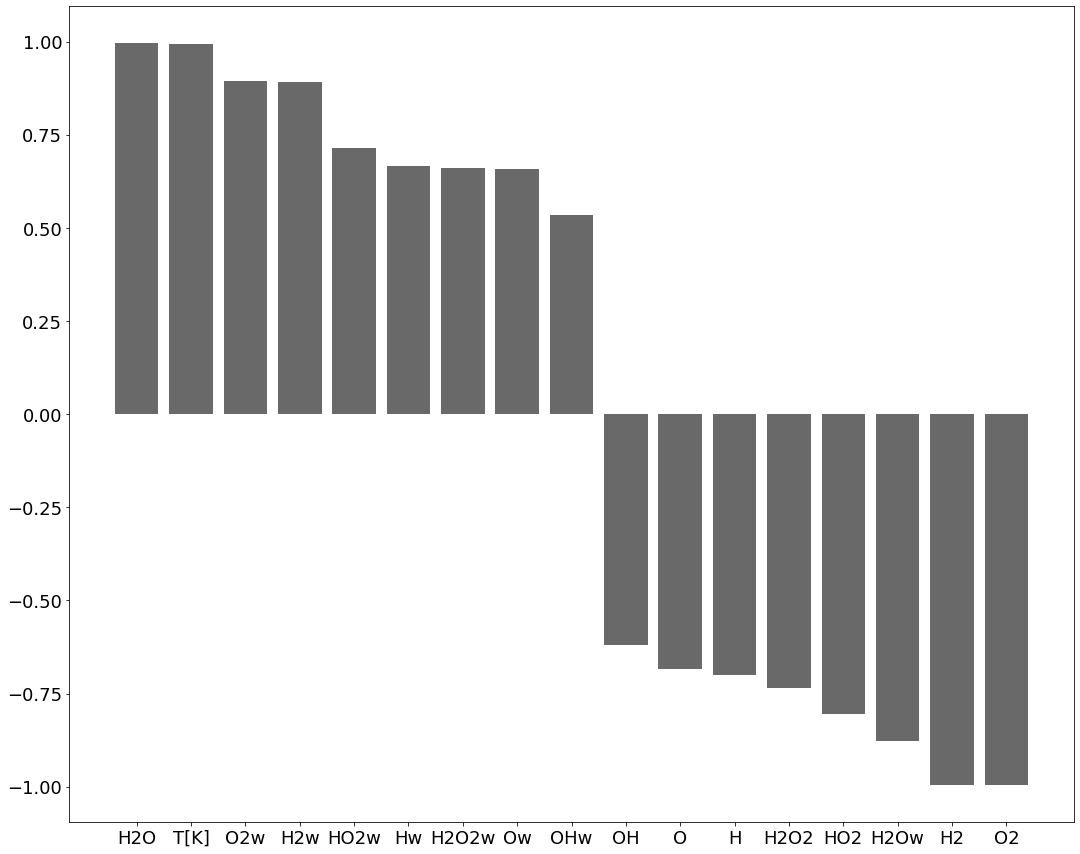

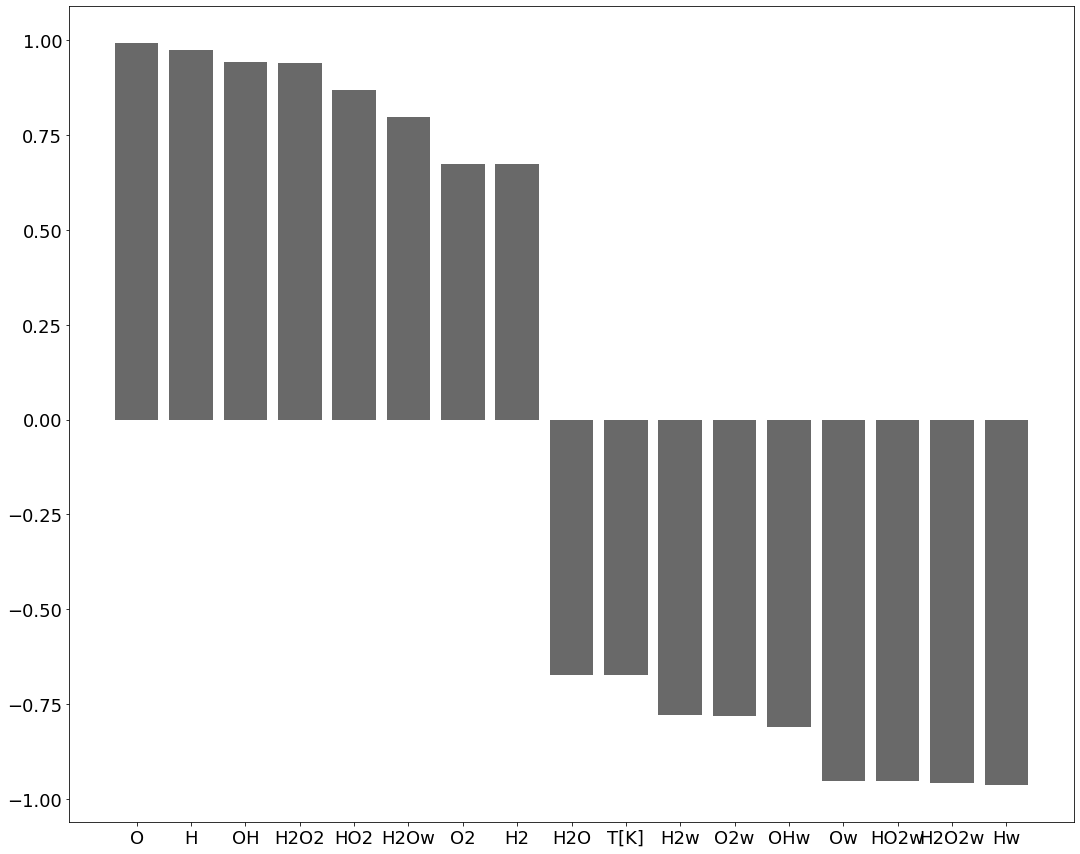

In [42]:
for m in range(reduced_size):
    
    indexes=corr_indexes.iloc[m,:].sort_values(ascending=False)
    x=indexes.keys()
    height=indexes.iloc[:].to_numpy()
    plt.figure(m,figsize=(18, 15))
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.bar(x,height,color='dimgray')
    plt.savefig('correlation_indexes_z'+str(m)+'.jpg',dpi=600)
    #axes=indexes.plot.bar(x='Chemical Specie', y='Corellation Index',rot=reduced_size, subplots=True)
    #axes[1].legend(loc=reduced_size)
    print(indexes)

In [18]:

if reduced_size==1:
    spearman_indexes=np.zeros(iterations) #rows, columns
    spearman_indexes=np.array([spearman_indexes])
    
    for j in range(iterations):
        spearman_indexes[:,j],_=stats.spearmanr(corr_dataset.iloc[:,j],latent_space)
    spearman_indexes=pd.DataFrame(spearman_indexes, columns=corr_columns)
else: 
    
    spearman_indexes=np.zeros((reduced_size,iterations)) #rows, columns
    
    for k in range(reduced_size):
        for j in range(iterations):
            spearman_indexes[k,j],_=stats.spearmanr(corr_dataset.iloc[:,j],latent_space[:,k])
    spearman_indexes=pd.DataFrame(spearman_indexes, columns=corr_columns)

In [19]:
spearman_indexes

,T[K],H2,H,O2,OH,O,H2O,HO2,H2O2,H2w,Hw,O2w,OHw,Ow,H2Ow,HO2w,H2O2w
0,0.999657,-0.999662,-0.569499,-0.999662,-0.464687,-0.545063,0.999662,-0.726036,-0.621727,0.914077,0.507170,0.916740,0.328902,0.494414,-0.892483,0.583013,0.501273
1,-0.534732,0.534727,0.971013,0.534727,0.932660,0.992889,-0.534727,0.822040,0.928770,-0.743977,-0.968574,-0.746881,-0.755142,-0.953051,0.771038,-0.954007,-0.961394


H2O      0.999662
T[K]     0.999657
O2w      0.916740
H2w      0.914077
HO2w     0.583013
Hw       0.507170
H2O2w    0.501273
Ow       0.494414
OHw      0.328902
OH      -0.464687
O       -0.545063
H       -0.569499
H2O2    -0.621727
HO2     -0.726036
H2Ow    -0.892483
H2      -0.999662
O2      -0.999662
Name: 0, dtype: float64
O        0.992889
H        0.971013
OH       0.932660
H2O2     0.928770
HO2      0.822040
H2Ow     0.771038
O2       0.534727
H2       0.534727
H2O     -0.534727
T[K]    -0.534732
H2w     -0.743977
O2w     -0.746881
OHw     -0.755142
Ow      -0.953051
HO2w    -0.954007
H2O2w   -0.961394
Hw      -0.968574
Name: 1, dtype: float64


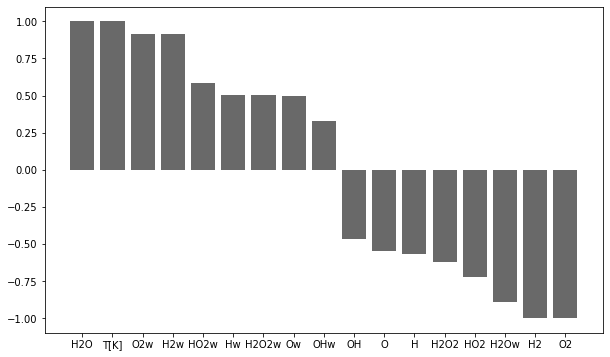

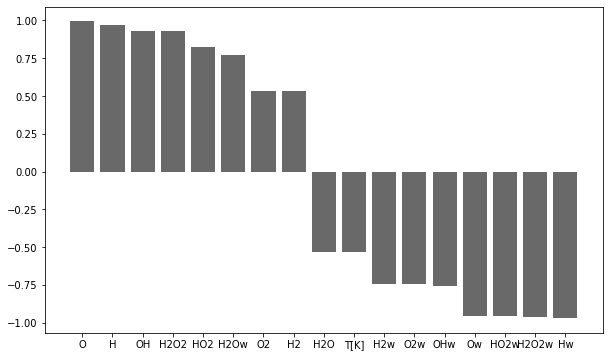

In [20]:
for m in range(reduced_size):
    
    indexes=spearman_indexes.iloc[m,:].sort_values(ascending=False)
    x=indexes.keys()
    height=indexes.iloc[:].to_numpy()
    plt.figure(m,figsize=(10, 6))
    plt.bar(x,height, color ='dimgray')
    #axes=indexes.plot.bar(x='Chemical Specie', y='Corellation Index',rot=reduced_size, subplots=True)
    #axes[1].legend(loc=reduced_size)
    print(indexes)

In [21]:
n_samples=np.shape(latent_space)[0]

corr_dataset_=corr_dataset.iloc[1:,:]

latent_space_=latent_space[0:n_samples-1,:]

In [22]:
print(np.shape(corr_dataset_))
print(np.shape(latent_space_))

(4998, 17)
(4998, 2)


In [23]:
iterations=np.shape(corr_dataset_)[1]

from scipy import stats 

if reduced_size==1:
    corr_indexes_=np.zeros(iterations) #rows, columns
    corr_indexes_=np.array([corr_indexes_])
    
    for j in range(iterations):
        corr_indexes_[:,j],_=stats.kendalltau(corr_dataset_.iloc[:,j],latent_space_)
    corr_indexes_=pd.DataFrame(corr_indexes_, columns=corr_columns)
else: 
    
    corr_indexes_=np.zeros((reduced_size,iterations)) #rows, columns
    
    for k in range(reduced_size):
        for j in range(iterations):
            corr_indexes_[k,j],_=stats.kendalltau(corr_dataset_.iloc[:,j],latent_space_[:,k])
    corr_indexes_=pd.DataFrame(corr_indexes_, columns=corr_columns)

In [24]:
corr_indexes_

,T[K],H2,H,O2,OH,O,H2O,HO2,H2O2,H2w,Hw,O2w,OHw,Ow,H2Ow,HO2w,H2O2w
0,0.994577,-0.994862,-0.701627,-0.994862,-0.621365,-0.684326,0.994862,-0.806342,-0.735240,0.890858,0.666502,0.893358,0.535146,0.657784,-0.877777,0.715203,0.662424
1,-0.673849,0.673564,0.974144,0.673564,0.943565,0.991422,-0.673564,0.869200,0.940542,-0.779588,-0.963933,-0.782452,-0.810595,-0.953496,0.798019,-0.953389,-0.959181


H2O      0.994862
T[K]     0.994577
O2w      0.893358
H2w      0.890858
HO2w     0.715203
Hw       0.666502
H2O2w    0.662424
Ow       0.657784
OHw      0.535146
OH      -0.621365
O       -0.684326
H       -0.701627
H2O2    -0.735240
HO2     -0.806342
H2Ow    -0.877777
H2      -0.994862
O2      -0.994862
Name: 0, dtype: float64
O        0.991422
H        0.974144
OH       0.943565
H2O2     0.940542
HO2      0.869200
H2Ow     0.798019
O2       0.673564
H2       0.673564
H2O     -0.673564
T[K]    -0.673849
H2w     -0.779588
O2w     -0.782452
OHw     -0.810595
HO2w    -0.953389
Ow      -0.953496
H2O2w   -0.959181
Hw      -0.963933
Name: 1, dtype: float64


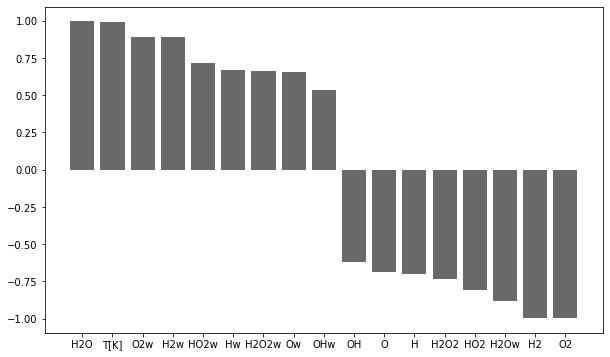

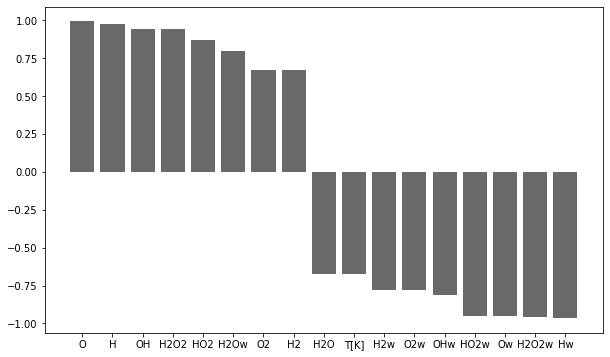

In [25]:
for m in range(reduced_size):
    
    indexes=corr_indexes_.iloc[m,:].sort_values(ascending=False)
    x=indexes.keys()
    height=indexes.iloc[:].to_numpy()
    plt.figure(m,figsize=(10, 6))
    plt.bar(x,height,color='dimgray')
    #axes=indexes.plot.bar(x='Chemical Specie', y='Corellation Index',rot=reduced_size, subplots=True)
    #axes[1].legend(loc=reduced_size)
    print(indexes)